# Importing packages

In [1]:
import json
from multiprocessing.dummy import Pool
import multiprocessing as mp

import torch
from transformers import AutoModel, AutoTokenizer, BertTokenizer
from tqdm import tqdm
import tensorflow_federated as tff
import numpy as np
from tensorflow import strings
import time
import pickle

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [2]:
torch.set_grad_enabled(False)

MODEL_NAME = "bert-base-uncased"
DEVICE = 'cuda'
INPUT_SIZE = 512

model = AutoModel.from_pretrained(MODEL_NAME)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

model.eval();
model.to(DEVICE);

In [3]:
stackoverflow_train, _, stackoverflow_test = tff.simulation.datasets.stackoverflow.load_data()

INFO:absl:Loaded 342477 client ids from SQL database.
INFO:absl:Loaded 38758 client ids from SQL database.
INFO:absl:Loaded 204088 client ids from SQL database.


In [ ]:
def client_caption(client_id):
    return strings.join(inputs=[x['tokens'] for x in stackoverflow_train.create_tf_dataset_for_client(client_id)], separator=' ')

In [4]:
CLIENT_NUM = 5000

In [ ]:
start_time = time.time()
pool = Pool(20)
res = pool.map(client_caption, stackoverflow_train.client_ids[:CLIENT_NUM])
pool.close()
pool.join()
print(time.time() - start_time)

In [5]:
client_ids = stackoverflow_train.client_ids[:CLIENT_NUM]

In [ ]:
with open('tf_strings_concatenated.data', 'wb') as file:
    pickle.dump(res, file)

In [6]:
with open('datasets/tf_strings_concatenated.data', 'rb') as file:
    res = pickle.load(file)

In [7]:
INPUT_SIZE = 500 # restricted by tokenizer

In [ ]:
batch_size = 256 # For batch_size=256 it takes about 3.5Gb of memory
all_embeddings = {}

captions = [x.numpy().decode("utf-8").lower()[:INPUT_SIZE] for x in res]

In [ ]:
embeddings = []

for start_idx in tqdm(range(0, len(captions), batch_size)):
    curr_captions = captions[start_idx : start_idx + batch_size]
    tokens = tokenizer(curr_captions, return_tensors="pt", padding=True)
    tokens = tokens.to(DEVICE)
    with torch.no_grad():
        outputs = model(**tokens)
    curr_embeddings = outputs.pooler_output.cpu()
    embeddings.extend(curr_embeddings)

# Now, we would like to match image ids with the embeddings
# so it will be easier for us to use it at test time
result = {client_id: [] for client_id in sorted(list(set(client_ids)))}
for client_id, emb in zip(client_ids, embeddings):
    result[client_id].append(emb)

# Now, let's save the resulted dict using pytorch save
torch.save(result, 'datasets/embeddings_{}.pt'.format(CLIENT_NUM))

In [8]:
result = torch.load('datasets/embeddings_5000.pt')

In [9]:
embeddings = [y[0] for _, y in result.items()]

# Two cluster of clients

## Set of clients

In [10]:
embeddings_ = [x.numpy() for x in embeddings]

In [11]:
numpy_embeddings = np.array(embeddings_)

In [12]:
numpy_embeddings.shape

(5000, 768)

In [13]:
import nest_asyncio
from utils_federated.datasets import stackoverflow_tag_prediction

In [14]:
nest_asyncio.apply()

In [15]:
train_fl, test_fl = stackoverflow_tag_prediction.get_federated_datasets(train_client_batch_size=500)

INFO:absl:Loaded 342477 client ids from SQL database.
INFO:absl:Loaded 38758 client ids from SQL database.
INFO:absl:Loaded 204088 client ids from SQL database.


In [16]:
test_client_ids = set(test_fl.client_ids)

In [17]:
participating_client_numbers = []
for i in range(CLIENT_NUM):
    curr_client_id = client_ids[i]
    if not curr_client_id in test_client_ids:
        continue
    
    client_dataset = test_fl.create_tf_dataset_for_client(curr_client_id)
    for element in client_dataset:
        if element[0].shape[0] >= 50:
            participating_client_numbers.append(i)
        break

In [18]:
participating_client_ids = [client_ids[i] for i in participating_client_numbers]

In [19]:
numpy_embeddings = numpy_embeddings[participating_client_numbers]

## KMeans

In [21]:
from sklearn.cluster import KMeans

In [22]:
number_of_clusters = 10

In [23]:
kmeans = KMeans(n_clusters=number_of_clusters, n_init=100, max_iter=1000, tol=1e-50, random_state=0, algorithm='full')

In [24]:
kmeans.fit(X=numpy_embeddings)

KMeans(algorithm='full', max_iter=1000, n_clusters=10, n_init=100,
       random_state=0, tol=1e-50)

## Clusters

In [25]:
import matplotlib.pyplot as plt

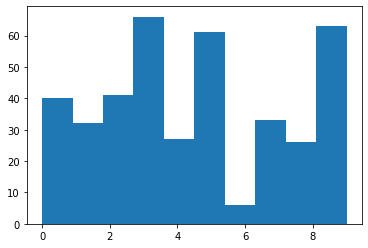

In [27]:
plt.hist(kmeans.labels_, bins=number_of_clusters);

In [28]:
label_count = np.zeros(shape=(number_of_clusters,))
for label in kmeans.labels_:
    label_count[label] += 1

In [29]:
label_count

array([40., 32., 41., 66., 27., 61.,  6., 33., 26., 63.])

In [30]:
over_40_labels = [i for i in range(number_of_clusters) if label_count[i] >= 40 ]

In [31]:
label_to_client = {label: [] for label in range(number_of_clusters)}

In [32]:
for idx in range(len(participating_client_numbers)):
    label_to_client[kmeans.labels_[idx]].append(participating_client_ids[idx])

In [33]:
for key in label_to_client:
    if len(label_to_client[key]) != label_count[key]:
        print('Error')

In [ ]:
# intersecting_label_to_client = {label: [] for label in over_40_labels}

In [ ]:
# test_clients_list = sorted(list(set(stackoverflow_test.client_ids)))
# for label in over_40_labels:
#     for client in label_to_client[label]:
#         if client in test_clients_list:
#             intersecting_label_to_client[label].append(client)

In [ ]:
# for label in intersecting_label_to_client:
#     print(label, len(intersecting_label_to_client[label]))

In [ ]:
# selected_labels = [label for label in intersecting_label_to_client if len(intersecting_label_to_client[label]) > 40]

In [34]:
selected_labels = over_40_labels

In [35]:
selected_labels

[0, 2, 3, 5, 9]

## Saving clients

In [36]:
for counter, label in enumerate(selected_labels):
    with open('datasets/clients_cluster_{}.data'.format(counter), 'wb') as file:
        pickle.dump(label_to_client[label], file)